In [49]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import json
import re
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import date,datetime

In [85]:
# Getting mortgage interest rates

def get_mortgage_rates():

    # stores all the data needed 
    mortgage_rates = pd.DataFrame()
    date = []
    year_30 = []
    year_15 = []
    apr = []
    # request data and finds section needed 
    res = requests.get('https://www.nerdwallet.com/blog/mortgages/current-interest-rates/')
    bs = BeautifulSoup(res.text,'lxml')
    search = bs.find_all('td')

    # loops through, finds each data and stores it
    for i in search[:2372]:
        if i.get('class')[0] == 'column-1':
            date.append(i.text)
            continue
        if i.get('class')[0] == 'column-2':
            year_30.append(i.text)
            continue
        if i.get('class')[0] == 'column-3':
            year_15.append(i.text)
            continue  
        if i.get('class')[0] == 'column-4':
            apr.append(i.text)
            continue 
    # stores list of data to df and cleans the format        
    mortgage_rates['Date'] = date
    mortgage_rates['Date'] = pd.to_datetime(mortgage_rates['Date'],errors ='coerce')
    mortgage_rates['30-year rate'] = year_30
    mortgage_rates['30-year rate'] = mortgage_rates['30-year rate'].str.extract('(\d\D\d)')
    mortgage_rates['30-year rate'] = mortgage_rates['30-year rate'].apply(float)
    mortgage_rates['15-year rate'] = year_15
    mortgage_rates['15-year rate'] = mortgage_rates['15-year rate'].str.extract('(\d\D\d)')
    mortgage_rates['15-year rate'] = mortgage_rates['15-year rate'].apply(float)
    mortgage_rates['ARM'] = apr
    mortgage_rates['ARM'] = mortgage_rates['ARM'].str.extract('(\d\D\d)')
    mortgage_rates['ARM'] = mortgage_rates['ARM'].apply(float)
    
    # creates the plots
    
    sns.set_theme(style='darkgrid')
    fig, ax = plt.subplots(figsize =(10, 8),dpi=150)
    ax = sns.lineplot(mortgage_rates['Date'], mortgage_rates['30-year rate'], 
                      label="30-year", linestyle='-',color='blue',marker='o')
    ax = sns.lineplot(mortgage_rates['Date'], mortgage_rates['15-year rate'], 
                      label="15-year", linestyle='-',color='red',marker='o')
    ax = sns.lineplot(mortgage_rates['Date'], mortgage_rates['ARM'], 
                      label="ARM", linestyle='-',color='purple',marker='o')

    ax.legend()
    plt.ylabel('Rate (%)',size=15)
    plt.xlabel('Dates',size=15)
    plt.title('Mortgage Rates')

    plt.gcf().autofmt_xdate()
    plt.savefig("Mortgage_Rates.png")
    plt.show()


/Users/faithful/anaconda3/envs/econdata/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/faithful/anaconda3/envs/econdata/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/faithful/anaconda3/envs/econdata/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result 

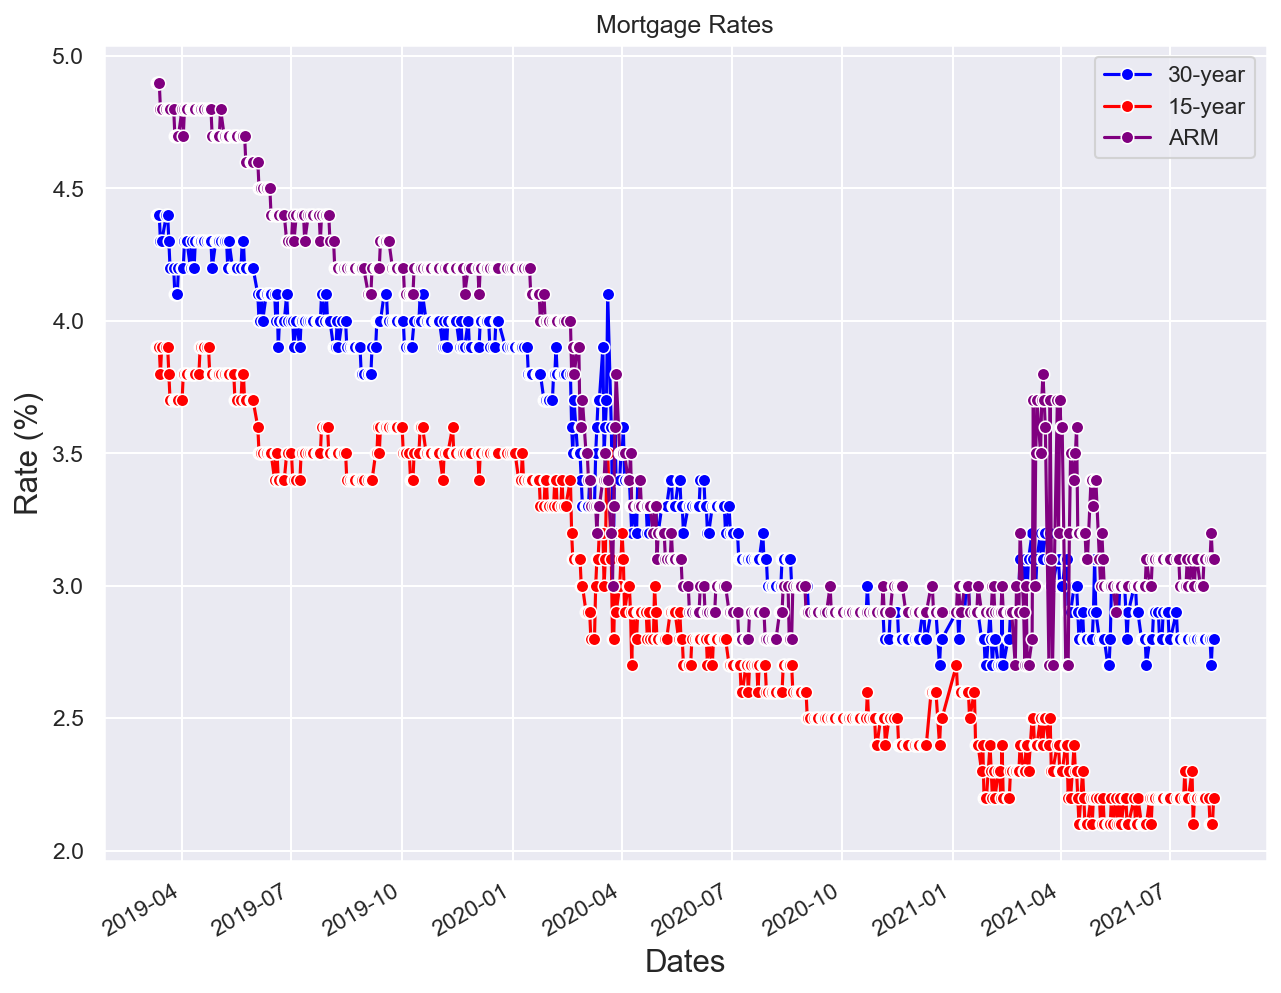

In [86]:
get_mortgage_rates()

# Getting The Treasury Rates

In [89]:
# Scrapping US treasury yield data
def format_treasury_rates(url):
    res_treasury = requests.get(url)
    bs_treasury = BeautifulSoup(res_treasury.text,'lxml')
    search_treasury = bs_treasury.find_all('td')

    treasury_rates_df = pd.DataFrame()
    treasury_rates = []
    treasury_dates = []
    count = 0

    # loop through skipping the first date and getting the rate back
    for i in search_treasury:
        if count == 1: 
            treasury_dates.append(i.text)
            count = 0
            continue
        if i.get('class'):
            if i.get('class')[0] == 'text-right':  
                count = 1
                treasury_rates.append(i.text)
    # variable to store the most recent date that didnt get scrapped
    all_dates = [date.today() - pd.to_timedelta('1D')]
    all_dates.extend(treasury_dates[:-1])

    treasury_rates_df['date'] = all_dates[:50]
    treasury_rates_df['date'] = pd.to_datetime(treasury_rates_df['date'])
    treasury_rates_df['rate'] = treasury_rates[:50]
    treasury_rates_df['rate'] = treasury_rates_df['rate'].apply(str.strip)
    treasury_rates_df['rate'] = treasury_rates_df['rate'].str.strip('%')
    
    return treasury_rates_df['rate'],treasury_rates_df['date']

In [92]:
def get_yield_curve():
    
    # gets & formats all the treasury rates data needed 
    rate_1m,date_1m = format_treasury_rates('https://ycharts.com/indicators/1_month_treasury_rate')
    rate_3m,date_3m = format_treasury_rates('https://ycharts.com/indicators/3_month_treasury_rate')
    rate_6m,date_6m = format_treasury_rates('https://ycharts.com/indicators/6_month_treasury_rate')
    rate_1,date_1 = format_treasury_rates('https://ycharts.com/indicators/1_year_treasury_rate')
    rate_3,date_3 = format_treasury_rates('https://ycharts.com/indicators/3_year_treasury_rate')
    rate_5,date_5 = format_treasury_rates('https://ycharts.com/indicators/5_year_treasury_rate')
    rate_10,date_10 = format_treasury_rates('https://ycharts.com/indicators/10_year_treasury_rate')
    rate_20,date_20 = format_treasury_rates('https://ycharts.com/indicators/20_year_treasury_rate')
    rate_30,date_30 = format_treasury_rates('https://ycharts.com/indicators/30_year_treasury_rate')
    
    # combines all the rates to a single df
    df_rates = pd.DataFrame()
    df_rates['1-mth'] = rate_1m.apply(float)
    df_rates['3-mth'] = rate_3m.apply(float)
    df_rates['6-mth'] = rate_6m.apply(float)
    df_rates['1-yr'] = rate_1.apply(float)
    df_rates['3-yr'] = rate_3.apply(float)
    df_rates['5-yr'] = rate_5.apply(float)
    df_rates['10-yr'] = rate_10.apply(float)
    df_rates['20-yr'] = rate_20.apply(float)
    df_rates['30-yr'] = rate_30.apply(float)
    
    # adds a data column using the 1month dates because all the dates are the same & makes it datetime
    df_rates['date'] = date_1
    df_rates.index = df_rates['date'].apply(pd.to_datetime)
    
    # stores the most recent treasury rates 
    yield_curve = df_rates.iloc[0,:-1]
    # plots the yield curve
    sns.set_theme(style='darkgrid')
    plt.figure(figsize=(10,8),dpi=150)
    plt.plot(yield_curve, linestyle='-',marker='o')
    plt.ylabel('Rate (%)',size=15)
    plt.xlabel('Treasury Yield',size=15)
    plt.title('Treasury Yield Curve')
    plt.savefig("Treasury_Yield_Curve.png")
    plt.show()


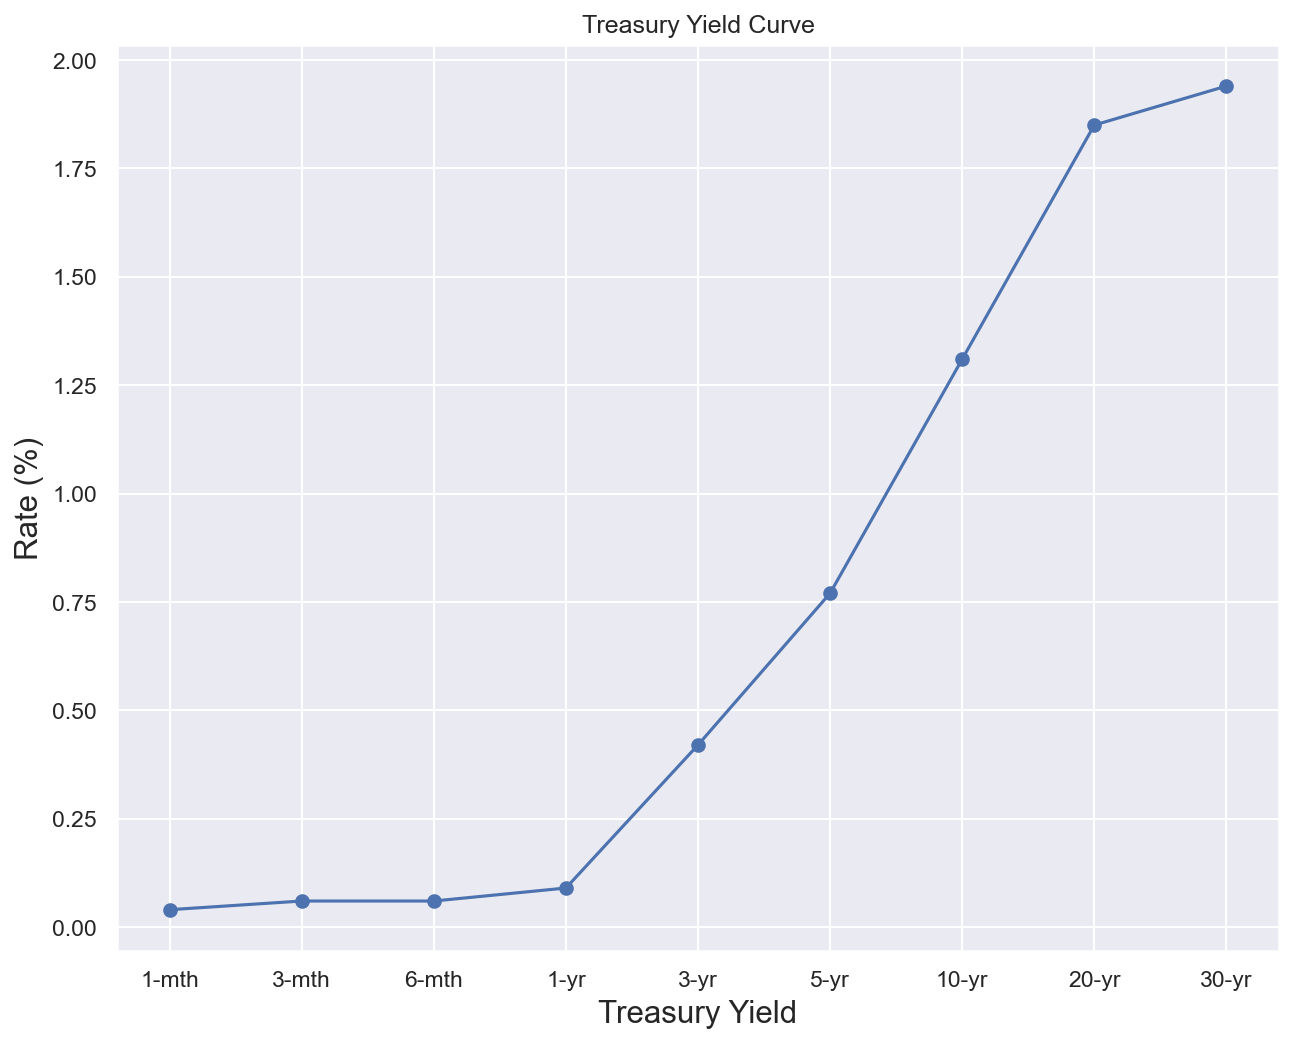

In [93]:
get_yield_curve()

# Getting the U-3 Unemployement Rate

In [122]:
def get_unemployment_rate():

    # request data and finds section needed 
    req = requests.get('https://data.bls.gov/timeseries/LNS14000000')
    bs = BeautifulSoup(req.content,'lxml')
    search = bs.find_all('td')

    # stores and counts necessary data
    count = 0
    years = 0
    time_list = []
    rates = []
    dates = []

    # loops through each rate for that year for the past 12 months
    for i in search[6:]:
        count = count + 1
        time_list.append(count)
        rates.append(i.text)
        if count == 12: 
            years = years + 1
            count = 0 
    # creates list of all the years for the data 12times 
    year_list = []
    for i in range(date.today().year-years+1,date.today().year+1):
        year_list.extend([i]*12)

    # converts date to dateitme in the right format
    count = 0
    for i in rates: 
        dates.append(pd.to_datetime(str(time_list[count])+'/1/'+str(year_list[count])))
        count = count + 1

    # storing and formating the data
    df_unemp_rate = pd.DataFrame()
    df_unemp_rate['date'] = dates
    df_unemp_rate['unemployment_rate_percent'] = rates  
    df_unemp_rate['unemployment_rate_percent'] = df_unemp_rate['unemployment_rate_percent'].str.strip()
    df_unemp_rate['unemployment_rate_percent'] = df_unemp_rate['unemployment_rate_percent'].replace('',np.nan)
    df_unemp_rate['unemployment_rate_percent'] = df_unemp_rate['unemployment_rate_percent'].apply(float)

    df_unemp_rate.index = df_unemp_rate['date']
    df_unemp_rate = df_unemp_rate.dropna()
    df_unemp_rate.sample(20)

    # plotting the data
    sns.set_theme(style='darkgrid')
    plt.figure(figsize=(10,8),dpi=150)
    sns.lineplot(data=df_unemp_rate['unemployment_rate_percent'],alpha=0.8,color='green',marker='o')
    plt.title('U-3 Unemployment Rate')
    plt.ylabel('Rate (%)',size=15)
    plt.xlabel('Year',size=15)
    plt.savefig("Unemployment_rate.png")
    plt.show()

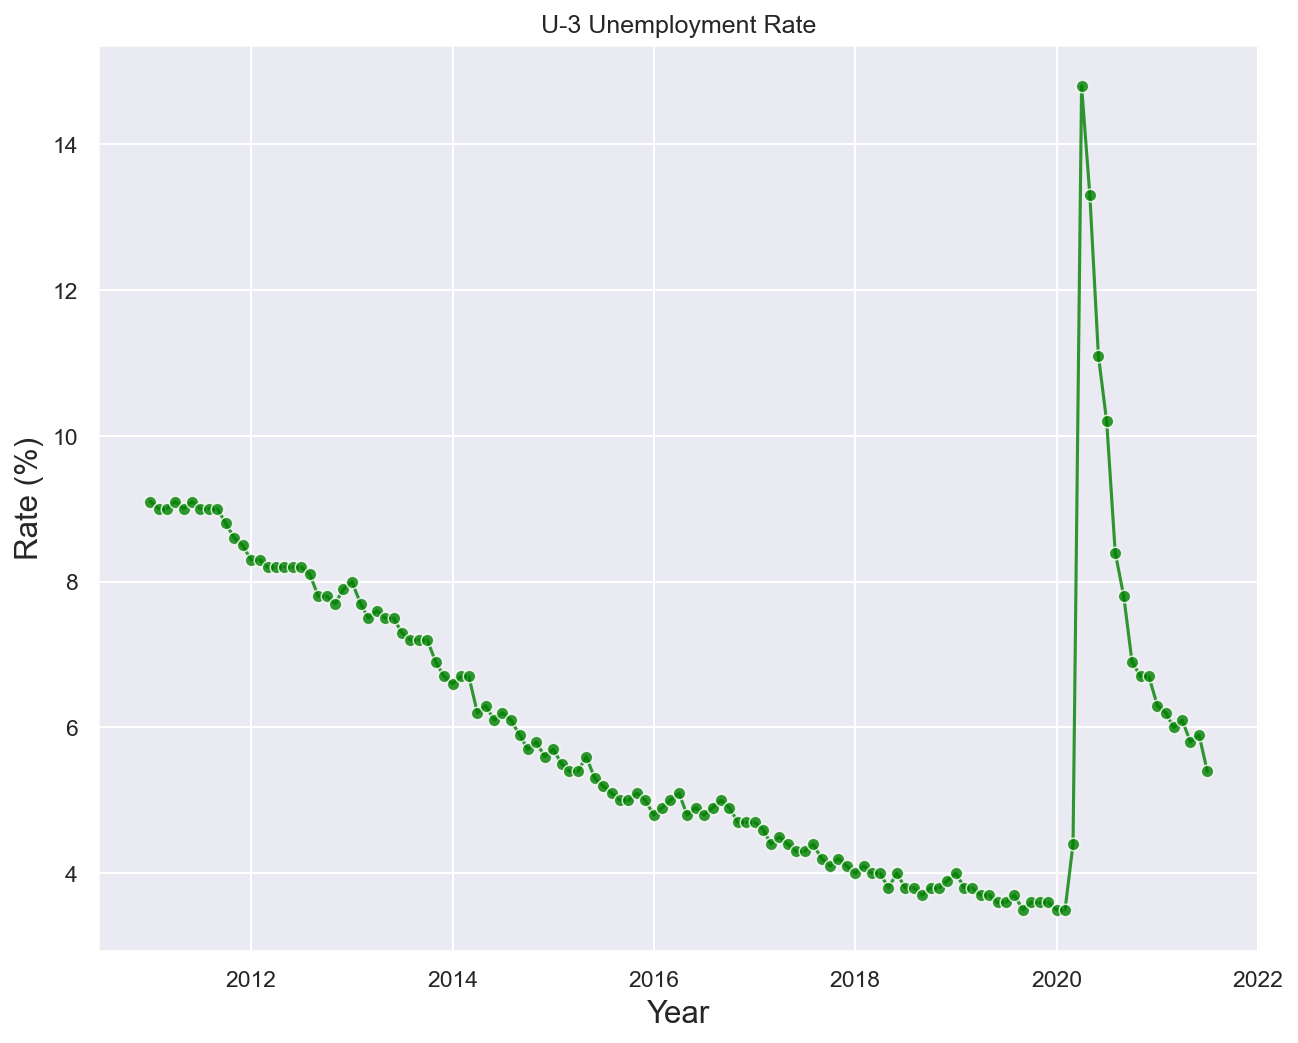

In [123]:
get_unemployment_rate()

# Getting the GDP Data

In [134]:

def get_gdp():
    req = requests.get('https://www.multpl.com/us-gdp-inflation-adjusted/table/by-year')
    bs = BeautifulSoup(req.content,'lxml')
    search = bs.find_all('td')

    dates = []
    gdp = []

    count = 0

    for i in search: 
        count += 1
        if count == 1:
            dates.append(i.text)
        if count == 2: 
            gdp.append(i.text)
            count = 0

    df_gdp = pd.DataFrame()
    df_gdp['date'] = dates
    df_gdp['date'] = df_gdp['date'].apply(pd.to_datetime)
    df_gdp['gdp'] = gdp
    df_gdp['gdp'] = df_gdp['gdp'].str.strip()
    df_gdp['gdp'] = df_gdp['gdp'].str.extract('(\d+\D\d+)')
    df_gdp['gdp'] = df_gdp['gdp'].apply(float)
    df_gdp.index = df_gdp['date']

    # plotting the data
    sns.set_theme(style='darkgrid')
    plt.figure(figsize=(10,8),dpi=150)
    sns.lineplot(data = df_gdp.iloc[df_gdp.index>'2011']['gdp'],marker='o',alpha=0.8,label='GDP',color='orange')

    plt.xlabel('Timeline',size=15)
    plt.ylabel('$ (Trillion)',size=15)
    plt.legend(prop={'size':10})
    plt.title('U.S. GDP')
    plt.savefig("US_GDP.png")
    plt.show()

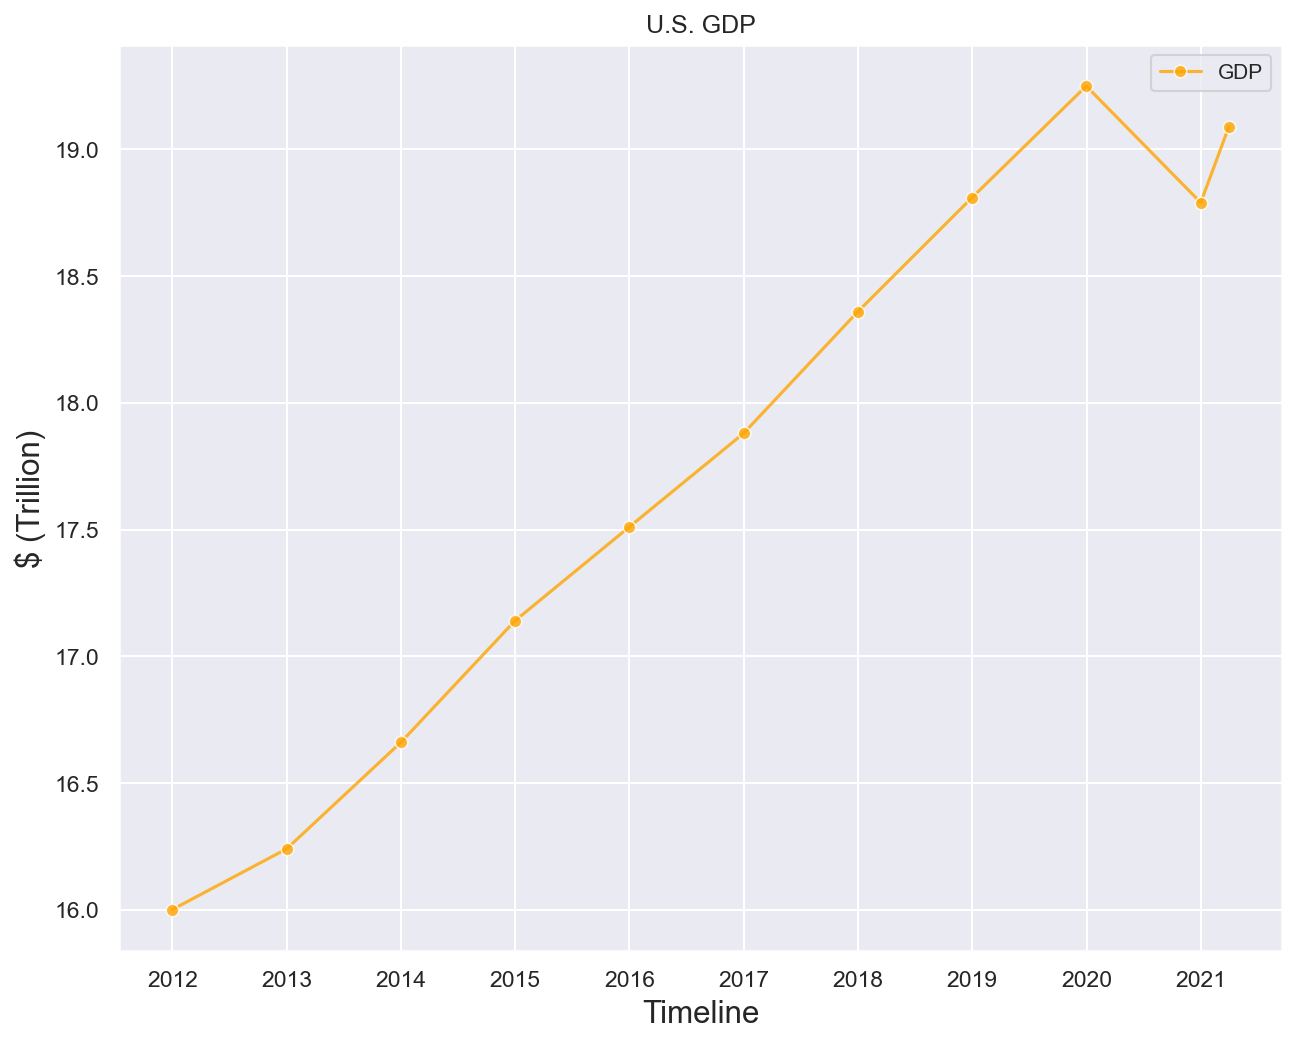

In [135]:
get_gdp()

# Getting Inflation Rate Data

In [146]:
def get_inflation_rate():
    req = requests.get('https://www.usinflationcalculator.com/inflation/historical-inflation-rates/')
    bs = BeautifulSoup(req.content,'lxml')
    search = bs.find_all('td')

    count = 0
    years = 0
    time_list = []
    rates = []
    dates = []

    for i in search:
        count = count + 1
        if count == 13:
            years = years + 1
            count = 0 
            continue
        time_list.append(count)
        rates.append(i.text)

    time_list = time_list[:-6]
    rates = rates[:-6]

    year_list = []
    for i in range(date.today().year-years+1,date.today().year+1):
        year_list.extend([i]*12)

    count = 0
    for i in rates: 
        dates.append(pd.to_datetime(str(time_list[count])+'/1/'+str(year_list[count])))
        count = count + 1

    df_inflation = pd.DataFrame()
    df_inflation['date'] = dates
    df_inflation['inflation_rate'] = rates  
    df_inflation['inflation_rate'] = df_inflation['inflation_rate'].str.strip()
    df_inflation['inflation_rate'] = df_inflation['inflation_rate'].replace('',np.nan)
    df_inflation['inflation_rate'] = df_inflation['inflation_rate'].apply(float)

    df_inflation.index = df_inflation['date']
    df_inflation = df_inflation.dropna()
    # plotting the data
    sns.set_theme(style='darkgrid')
    plt.figure(figsize=(10,8),dpi=150)
    sns.lineplot(data = df_inflation.iloc[df_inflation.index>'2011']['inflation_rate'],marker='o',
                 alpha=0.8,label='Inflation rate (%)',color='blue')

    plt.xlabel('Timeline',size=15)
    plt.ylabel('Rate (%)',size=15)
    plt.legend(prop={'size':10})
    plt.title('U.S. Inflation Rate')
    plt.savefig("US_Inflation_Rate.png")
    plt.show()


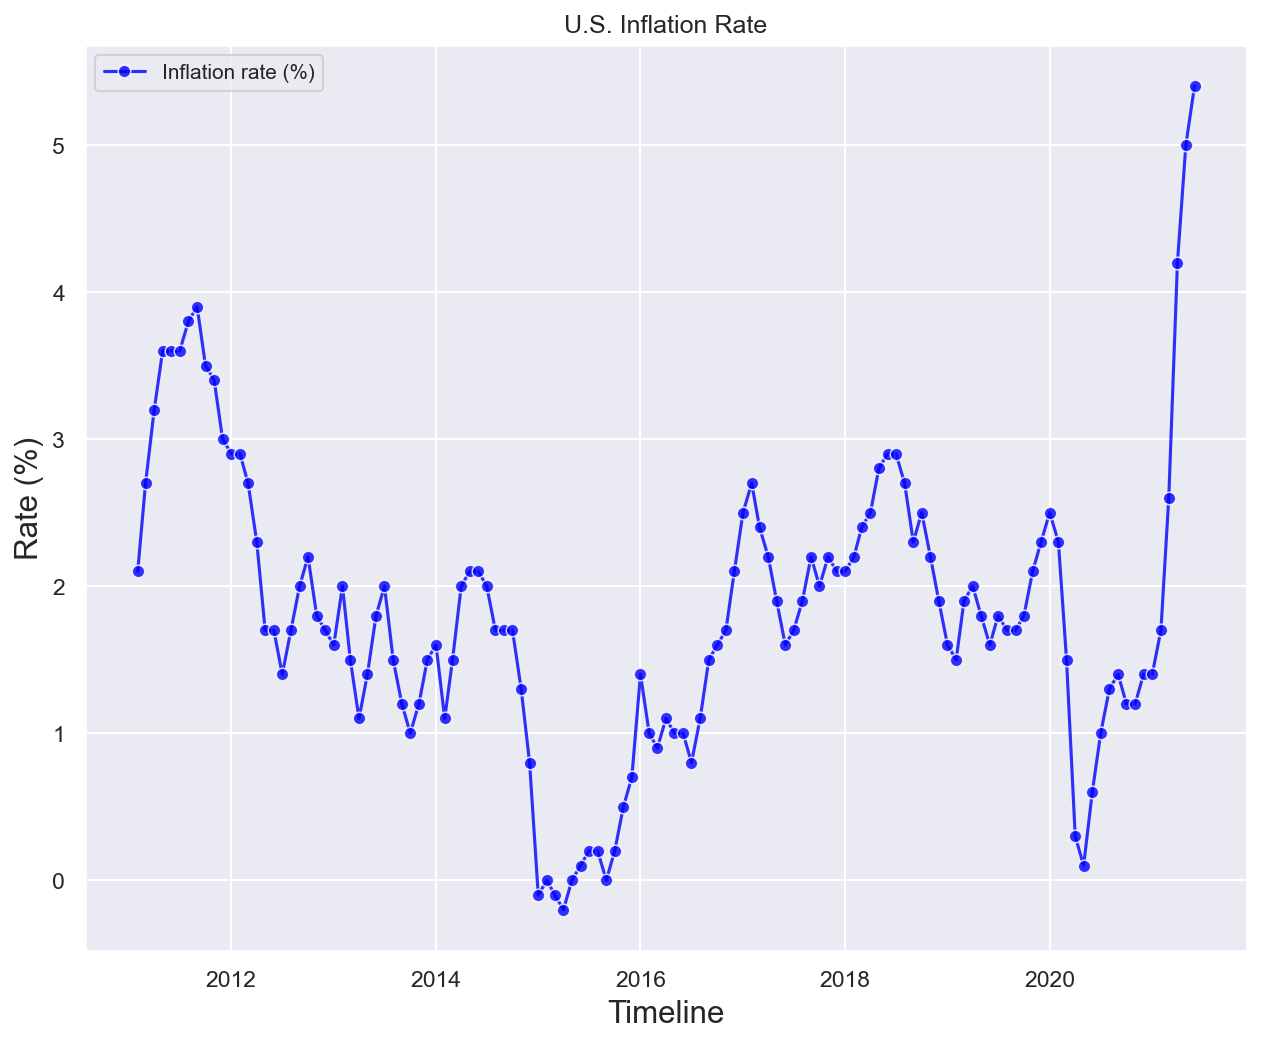

In [147]:
get_inflation_rate()